# Results for ipyrad/pyrad/stacks simulated & emprical analyses

In [29]:
## Prereqs for plotting and analysis
#!conda install matplotlib
#!pip install vcfnp
#!pip install scikit-allel
#!conda install -y seaborn

Using Anaconda Cloud api site https://api.anaconda.org
Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /home/iovercast/opt/miniconda:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seaborn-0.7.1              |           py27_0         272 KB

The following NEW packages will be INSTALLED:

    seaborn: 0.7.1-py27_0

Fetching packages ...
seaborn-0.7.1- 100% |################################| Time: 0:00:00   4.14 MB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Linking packages ...
[      COMPLETE      ]|###################################################| 100%


In [81]:
## Imports and working/output directories directories

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas as pd
import numpy as np
import collections
import allel
import vcfnp
import os

## Set the default directories for exec and data. 
WORK_DIR="/home/iovercast/manuscript-analysis/"
EMPERICAL_DATA_DIR=os.path.join(WORK_DIR, "example_empirical_rad/")
IPYRAD_DIR=os.path.join(WORK_DIR, "ipyrad/")
PYRAD_DIR=os.path.join(WORK_DIR, "pyrad/")
STACKS_DIR=os.path.join(WORK_DIR, "stacks/")

IPYRAD_OUTPUT=os.path.join(IPYRAD_DIR, "REALDATA/")
PYRAD_OUTPUT=os.path.join(PYRAD_DIR, "REALDATA/")
STACKS_OUTPUT=os.path.join(STACKS_DIR, "REALDATA/")
STACKS_GAP_OUT=os.path.join(STACKS_OUTPUT, "gapped/")
STACKS_UNGAP_OUT=os.path.join(STACKS_OUTPUT, "ungapped/")
STACKS_DEFAULT_OUT=os.path.join(STACKS_OUTPUT, "default/")

## tmp for testing
#IPYRAD_OUTPUT = "./arch/ipyrad/REALDATA/"
#PYRAD_OUTPUT = "./arch/pyrad/REALDATA/"
IPYRAD_STATS = os.path.join(IPYRAD_OUTPUT, "REALDATA_outfiles/REALDATA_stats.txt")
PYRAD_STATS = os.path.join(PYRAD_OUTPUT, "stats/c85d6m2p3H3N3.stats")

os.chdir(WORK_DIR)

## Function for plotting PCA given an input vcf file

In [2]:
def plotPCA(filename, title):
    c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    sns.despine(ax=ax, offset=5)
    x = coords1[:, 0]
    y = coords1[:, 1]
    for sp in species:
        flt = (np.array(species_dict.values()) == sp)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=species_colors[sp], label=sp, markersize=10, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title+" pca", y=1.02, style="italic", fontsize=20, fontweight='bold')
    fig.tight_layout()
    
def plotPairwiseDistance(filename, title):
    c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=species_dict.keys())

## Get sample names, species names, and the species_dict

In [3]:
## Get sample names and assign them to a species dict
infile = open(IPYRAD_STATS).readlines()
sample_names = [x.strip().split()[0] for x in infile[20:33]]
species = set([x.split("_")[1] for x in sample_names])
species_dict = collections.OrderedDict([])

## Ordered dict of sample names and their species, in same order
## as the vcf file
for s in sample_names:
    species_dict[s] = s.split("_")[1]
print(species_dict)

## Map species names to groups of individuals
#for s in species:
#    species_dict[s] = [x for x in sample_names if s in x]
#print(species_dict)
species_colors = {
    'rex': '#FF0000',
    'cyathophylla': '#008000',
    'thamno': '#00FFFF',
    'cyathophylloides': '#90EE90',
    'przewalskii': '#FFA500',
    'superba': '#8B0000',
}

OrderedDict([('29154_superba', 'superba'), ('30556_thamno', 'thamno'), ('30686_cyathophylla', 'cyathophylla'), ('32082_przewalskii', 'przewalskii'), ('33413_thamno', 'thamno'), ('33588_przewalskii', 'przewalskii'), ('35236_rex', 'rex'), ('35855_rex', 'rex'), ('38362_rex', 'rex'), ('39618_rex', 'rex'), ('40578_rex', 'rex'), ('41478_cyathophylloides', 'cyathophylloides'), ('41954_cyathophylloides', 'cyathophylloides')])


In [111]:
## Make a new pandas dataframe for holding the coverage results
sim_coverage_df = pd.DataFrame()

## ipyrad simulated results

In [112]:
## ipyrad stats
IPYRAD_SIMOUT=os.path.join(IPYRAD_DIR, "SIMDATA/")
for sim in ["no", "lo", "hi"]: #, "large"]:
    print("Doing - {}".format(sim))
    simdir = os.path.join(IPYRAD_SIMOUT, "sim"+sim)
    statsfile = simdir + "/sim{}_outfiles/sim{}_stats.txt".format(sim, sim)
    infile = open(statsfile).readlines()
    sample_coverage = [int(x.strip().split()[1]) for x in infile[20:32]]
    print(sample_coverage)
    print("mean sample coverage - {}".format(np.mean(sample_coverage)))
    print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))
    sim_coverage_df["ipyrad_"+sim] = sample_coverage
print(sim_coverage_df)

Doing - no
[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
mean sample coverage - 10000.0
min/max - 10000/10000
Doing - lo
[9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999]
mean sample coverage - 9999.0
min/max - 9999/9999
Doing - hi
[9999, 9999, 9999, 9998, 9999, 9999, 9998, 9999, 9999, 9999, 9999, 9999]
mean sample coverage - 9998.83333333
min/max - 9998/9999
    ipyrad_no  ipyrad_lo  ipyrad_hi
0       10000       9999       9999
1       10000       9999       9999
2       10000       9999       9999
3       10000       9999       9998
4       10000       9999       9999
5       10000       9999       9999
6       10000       9999       9998
7       10000       9999       9999
8       10000       9999       9999
9       10000       9999       9999
10      10000       9999       9999
11      10000       9999       9999


## pyrad simulated results

In [113]:
## ipyrad stats
PYRAD_SIMOUT=os.path.join(PYRAD_DIR, "SIMDATA/")
for sim in ["no", "lo", "hi"]: #, "large"]:
    print("Doing - ", sim)
    simdir = os.path.join(PYRAD_SIMOUT, "sim"+sim)
    statsfile = simdir + "/stats/c85d6m2p3H3N3.stats".format(sim, sim)
    infile = open(statsfile).readlines()
    sample_coverage = [int(x.strip().split()[1]) for x in infile[8:20]]
    print(sample_coverage)
    print("mean sample coverage - {}".format(np.mean(sample_coverage)))
    print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))
    sim_coverage_df["pyrad_"+sim] = sample_coverage
print(sim_coverage_df)

('Doing - ', 'no')
[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
mean sample coverage - 10000.0
min/max - 10000/10000
('Doing - ', 'lo')
[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]
mean sample coverage - 10000.0
min/max - 10000/10000
('Doing - ', 'hi')
[10000, 10000, 10000, 10000, 10000, 10000, 9999, 10000, 10000, 10000, 10000, 10000]
mean sample coverage - 9999.91666667
min/max - 9999/10000
    ipyrad_no  ipyrad_lo  ipyrad_hi  pyrad_no  pyrad_lo  pyrad_hi
0       10000       9999       9999     10000     10000     10000
1       10000       9999       9999     10000     10000     10000
2       10000       9999       9999     10000     10000     10000
3       10000       9999       9998     10000     10000     10000
4       10000       9999       9999     10000     10000     10000
5       10000       9999       9999     10000     10000     10000
6       10000       9999       9998     10000     10000      99

## stacks simulated results

In [114]:
## stacks stats
STACKS_SIMOUT=os.path.join(STACKS_DIR, "SIMDATA/")
STACKS_GAP_SIMOUT=os.path.join(STACKS_SIMOUT, "gapped/")
STACKS_UNGAP_SIMOUT=os.path.join(STACKS_SIMOUT, "ungapped/")
STACKS_DEFAULT_SIMOUT=os.path.join(STACKS_SIMOUT, "default/")

for dir in [STACKS_GAP_SIMOUT, STACKS_UNGAP_SIMOUT, STACKS_DEFAULT_SIMOUT]:
    for sim in ["no", "lo", "hi"]: #, "large"]:
        print("Doing - {} - {}".format(dir, sim))
        try:
            simdir = os.path.join(dir, "sim"+sim)
            lines = open(os.path.join(simdir, "batch_1.haplotypes.tsv")).readlines()
            cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
            shigh = [cnts.count(i) for i in range(1,13)]
            sample_coverage = [int(sum(shigh)-sum(shigh[:i-1])) for i in range(1,13)]

            print(SHIGH)
            stacks_method = dir.split("/")[-2]
            sim_coverage_df["stacks_"+stacks_method+"_"+sim] = sample_coverage
        except:
            pass
print(sim_coverage_df)

Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/ - no
[16741, 12076, 11198, 10443, 9543, 9437, 9339, 9123, 8315, 7915, 7450, 5805]
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/ - lo
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/gapped/ - hi
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/ - no
[16741, 12076, 11198, 10443, 9543, 9437, 9339, 9123, 8315, 7915, 7450, 5805]
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/ - lo
[16741, 12076, 11198, 10443, 9543, 9437, 9339, 9123, 8315, 7915, 7450, 5805]
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/ungapped/ - hi
[16741, 12076, 11198, 10443, 9543, 9437, 9339, 9123, 8315, 7915, 7450, 5805]
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/default/ - no
[16741, 12076, 11198, 10443, 9543, 9437, 9339, 9123, 8315, 7915, 7450, 5805]
Doing - /home/iovercast/manuscript-analysis/stacks/SIMDATA/default/ - lo
Doing - /home/iovercast/manuscr

## Plotting simulation results

In [115]:
print("Mean sample coverage:")
for col in sim_coverage_df:
    print("\t{} - {}".format(col, np.mean(sim_coverage_df[col])))

Mean sample coverage:
	ipyrad_no - 10000.0
	ipyrad_lo - 9999.0
	ipyrad_hi - 9998.83333333
	pyrad_no - 10000.0
	pyrad_lo - 10000.0
	pyrad_hi - 9999.91666667
	stacks_gapped_no - 9971.0
	stacks_ungapped_no - 9971.0
	stacks_ungapped_lo - 10004.3333333
	stacks_ungapped_hi - 10036.8333333
	stacks_default_no - 9697.75
	stacks_default_hi - 9789.83333333


# Empirical Results (Pedicularis)

## ipyrad Empirical results

In [60]:
## ipyrad stats

infile = open(IPYRAD_STATS).readlines()
sample_coverage = [int(x.strip().split()[1]) for x in infile[20:33]]
print(sample_coverage)
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))

[19792, 30546, 26251, 19505, 16278, 21713, 31992, 32080, 34204, 27482, 33539, 36638, 33104]
mean sample coverage - 27932.6153846
min/max - 16278/36638


[vcfnp] 2016-09-04 14:19:48.358803 :: caching is disabled
[vcfnp] 2016-09-04 14:19:48.360155 :: building array


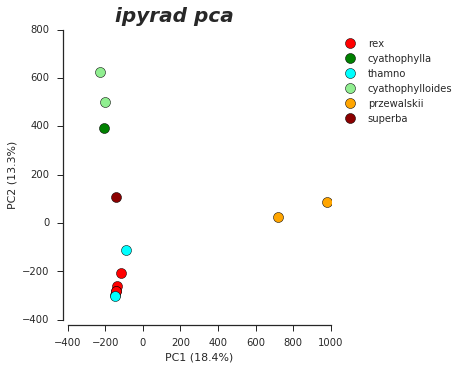

In [83]:
## Have to gunzip the ipyrad REALDATA vcf
filename = os.path.join(IPYRAD_OUTPUT, "REALDATA_outfiles/REALDATA.vcf")
plotPCA(filename, "ipyrad")

## pyRAD empirical results

In [68]:
## pyrad stats

infile = open(PYRAD_STATS).readlines()
sample_coverage = [int(x.strip().split()[1]) for x in infile[8:21]]
print(sample_coverage)
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))

[23924, 37002, 31852, 23698, 20063, 26050, 38931, 39423, 41250, 33230, 40809, 42948, 38645]
mean sample coverage - 33678.8461538
min/max - 20063/42948


[vcfnp] 2016-09-03 18:32:22.899103 :: caching is disabled
[vcfnp] 2016-09-03 18:32:22.899671 :: building array


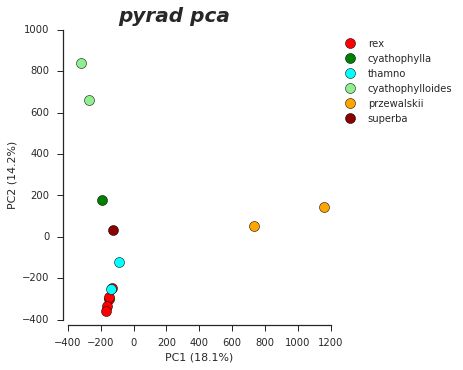

In [76]:
filename = os.path.join(PYRAD_OUTPUT, "outfiles/c85d6m2p3H3N3.vcf")
plotPCA(filename, "pyrad")

## stacks empirical results

[vcfnp] 2016-09-03 18:47:19.660343 :: caching is disabled
[vcfnp] 2016-09-03 18:47:19.660845 :: building array


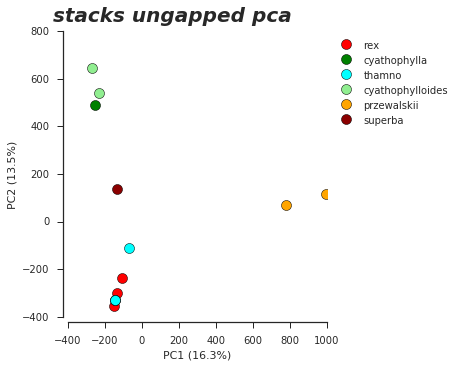

In [8]:
lines = open("SIMsmall/stackf_high/batch_1.haplotypes.tsv").readlines()
cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
shigh = [cnts.count(i) for i in range(1,13)]

filename = os.path.join(STACKS_OUTPUT, "ungapped/batch_1.vcf")
plotPCA(filename, "stacks ungapped")

[vcfnp] 2016-09-03 21:52:05.661915 :: caching is disabled
[vcfnp] 2016-09-03 21:52:05.662672 :: building array


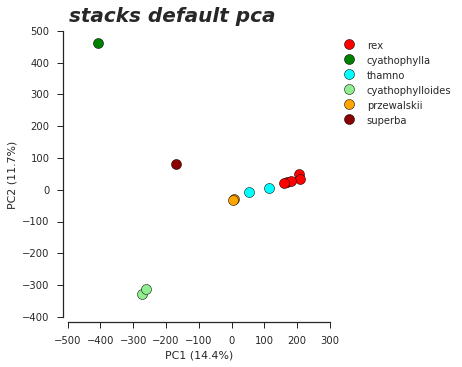

In [19]:
filename = os.path.join(STACKS_OUTPUT, "default/batch_1.vcf")
plotPCA(filename, "stacks default")

[vcfnp] 2016-09-03 21:45:09.937452 :: caching is disabled
[vcfnp] 2016-09-03 21:45:09.938025 :: building array


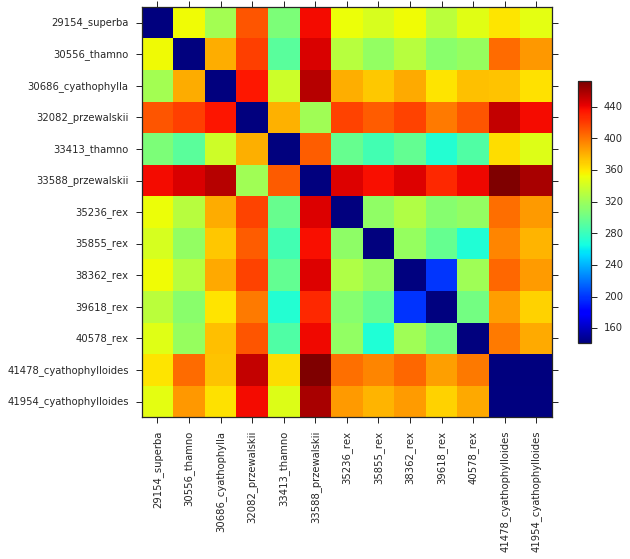

In [17]:
filename = os.path.join(IPYRAD_OUTPUT, "REALDATA_outfiles/REALDATA.vcf")
plotPairwiseDistance(filename, "pyrad")

[vcfnp] 2016-09-03 21:48:18.232723 :: caching is disabled
[vcfnp] 2016-09-03 21:48:18.233306 :: building array


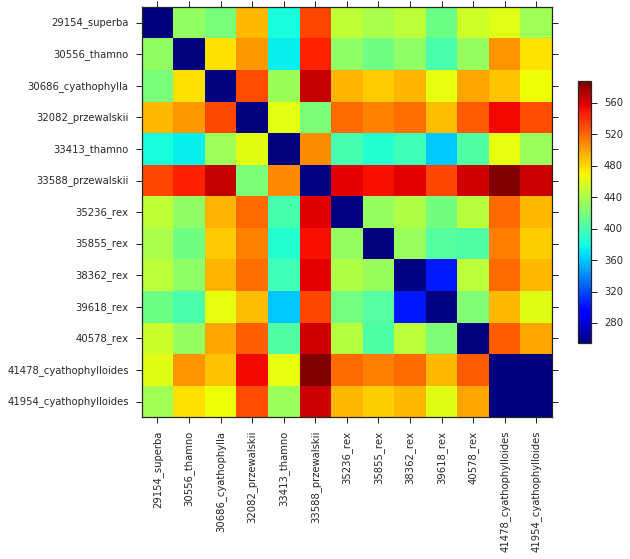

In [18]:
filename = os.path.join(PYRAD_OUTPUT, "outfiles/c85d6m2p3H3N3.vcf")
plotPairwiseDistance(filename, "pyrad")

[vcfnp] 2016-09-03 18:56:31.855138 :: caching is disabled
[vcfnp] 2016-09-03 18:56:31.855756 :: building array


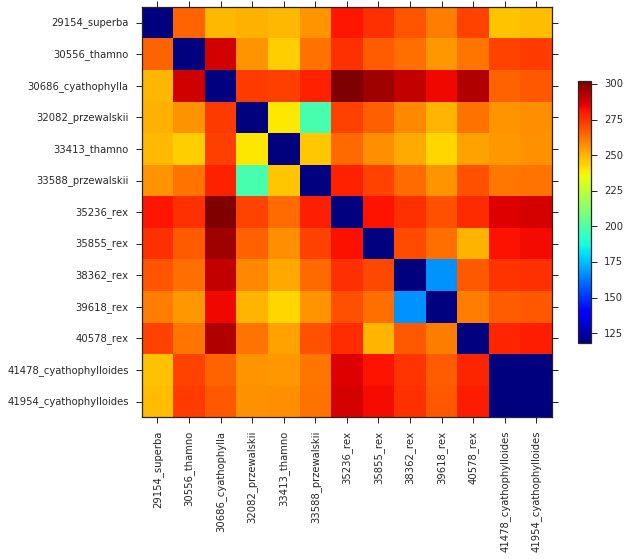

In [12]:
filename = os.path.join(STACKS_OUTPUT, "default/batch_1.vcf")
plotPairwiseDistance(filename, "stacks default")

[vcfnp] 2016-09-03 19:04:05.829749 :: caching is disabled
[vcfnp] 2016-09-03 19:04:05.830278 :: building array


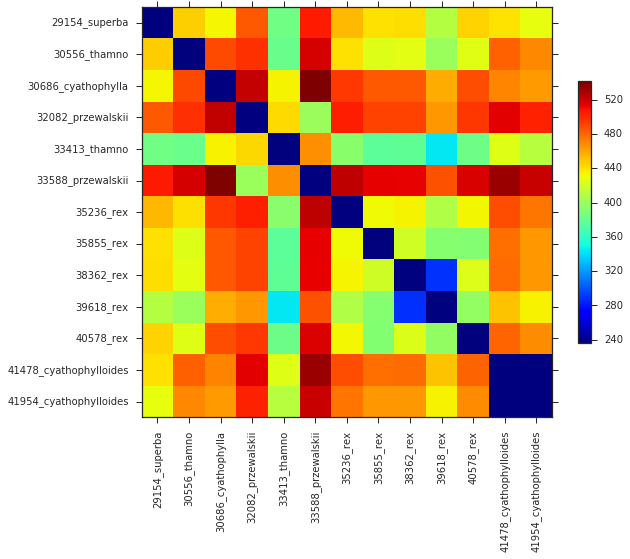

In [16]:
filename = os.path.join(STACKS_OUTPUT, "ungapped/batch_1.vcf")
plotPairwiseDistance(filename, "stacks ungapped")

In [59]:
filename = os.path.join(IPYRAD_OUTPUT, "REALDATA_outfiles/REALDATA.vcf")
v = vcfnp.variants(filename).view(np.recarray)

[vcfnp] 2016-09-03 22:30:17.582714 :: caching is disabled
[vcfnp] 2016-09-03 22:30:17.583402 :: building array


In [66]:
print(v.dtype)
print(v.CHROM)
print(len(v.CHROM))
print(len(set(v.CHROM)))
v[0]


(numpy.record, [('CHROM', 'S12'), ('POS', '<i4'), ('ID', 'S12'), ('REF', 'S12'), ('ALT', 'S12'), ('QUAL', '<f4'), ('FILTER', [('PASS', '?')]), ('num_alleles', 'u1'), ('is_snp', '?'), ('svlen', '<i4'), ('DP', '<i4'), ('NS', '<i4')])
['7' '7' '7' ..., '77230' '77230' '77230']
2403313
34734


2403313

In [50]:
filename = os.path.join(PYRAD_OUTPUT, "outfiles/c85d6m2p3H3N3.vcf")
v = vcfnp.variants(filename).view(np.recarray)

[vcfnp] 2016-09-03 22:25:58.965949 :: caching is disabled
[vcfnp] 2016-09-03 22:25:58.966602 :: building array


In [56]:
print(v.dtype)
print(v.CHROM)
print(len(v.CHROM))
print(len(set(v.CHROM)))


(numpy.record, [('CHROM', 'S12'), ('POS', '<i4'), ('ID', 'S12'), ('REF', 'S12'), ('ALT', 'S12'), ('QUAL', '<f4'), ('FILTER', [('PASS', '?')]), ('num_alleles', 'u1'), ('is_snp', '?'), ('svlen', '<i4'), ('AA', 'S12'), ('AF', '<f2'), ('DP', '<i4'), ('NS', '<i4')])
['1' '1' '1' ..., '158401' '158401' '158401']
322689
62812


In [48]:
filename = os.path.join(STACKS_OUTPUT, "ungapped/batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)

[vcfnp] 2016-09-03 22:25:38.632822 :: caching is disabled
[vcfnp] 2016-09-03 22:25:38.633529 :: building array


In [49]:
print(v.ID)
print(len(v.ID))
print(len(set([x.split("_")[0] for x in v.ID])))


['1_6' '1_14' '1_27' ..., '614361_45' '614386_71' '614406_58']
344633
76984


In [17]:
filename = os.path.join(STACKS_OUTPUT, "default/batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-09-04 18:26:17.357994 :: caching is disabled
[vcfnp] 2016-09-04 18:26:17.359006 :: building array
[vcfnp] 2016-09-04 18:26:21.250084 :: caching is disabled
[vcfnp] 2016-09-04 18:26:21.251127 :: building array


In [37]:
import itertools
import numpy.ma as ma
print(v.ID)
print(len(v.ID))
loc_list = []
loci = set([x.split("_")[0] for x in v.ID])
print(len(loci))
loc_list = [list(val) for key,val in itertools.groupby(v.ID,key=lambda x:x.split("_")[0])]

print(len(loc_list))
## experimentation
print(v.dtype)
print(c.dtype)

print(np.mean(c.DP))
print(loc_list[0:10])
subsamp = np.array([np.random.choice(x, 1, replace=False)[0] for x in loc_list])
mask = np.in1d(v.ID, subsamp)

['4_35' '4_62' '5_56' ..., '496594_58' '496602_66' '496604_59']
149570
82955
82955
(numpy.record, [('CHROM', 'S12'), ('POS', '<i4'), ('ID', 'S12'), ('REF', 'S12'), ('ALT', 'S12'), ('QUAL', '<f4'), ('FILTER', [('PASS', '?')]), ('num_alleles', 'u1'), ('is_snp', '?'), ('svlen', '<i4'), ('AF', '<f2'), ('NS', '<i4')])
(numpy.record, [('is_called', '?'), ('is_phased', '?'), ('genotype', 'i1', (2,)), ('AD', '<u2', (2,)), ('DP', '<u2'), ('GL', '<f4'), ('GT', 'S3')])
5.95418198837
[['4_35', '4_62'], ['5_56', '5_62', '5_68'], ['6_61', '6_68'], ['7_67'], ['8_5', '8_41', '8_65'], ['11_40'], ['13_49', '13_71'], ['15_6', '15_10', '15_24', '15_34'], ['16_26'], ['17_17', '17_26', '17_27', '17_66']]


In [53]:
print(subsamp[2])
cmask = c[mask]
print(cmask[2])
print(c[5])

6_61
[ (False, False, array([-1, -1], dtype=int8), array([0, 0], dtype=uint16), 0, 0.0, './.')
 (True, False, array([0, 1], dtype=int8), array([45, 22], dtype=uint16), 67, 0.0, '0/1')
 (False, False, array([-1, -1], dtype=int8), array([0, 0], dtype=uint16), 0, 0.0, './.')
 (False, False, array([-1, -1], dtype=int8), array([0, 0], dtype=uint16), 0, 0.0, './.')
 (True, False, array([0, 1], dtype=int8), array([23,  8], dtype=uint16), 31, 0.0, '0/1')
 (False, False, array([-1, -1], dtype=int8), array([0, 0], dtype=uint16), 0, 0.0, './.')
 (False, False, array([-1, -1], dtype=int8), array([0, 0], dtype=uint16), 0, 0.0, './.')
 (True, False, array([0, 0], dtype=int8), array([34,  0], dtype=uint16), 34, -7.75, '0/0')
 (True, False, array([0, 1], dtype=int8), array([32, 14], dtype=uint16), 46, 0.0, '0/1')
 (False, False, array([-1, -1], dtype=int8), array([0, 0], dtype=uint16), 0, 0.0, './.')
 (True, False, array([0, 1], dtype=int8), array([67, 25], dtype=uint16), 92, 0.0, '0/1')
 (False, Fals

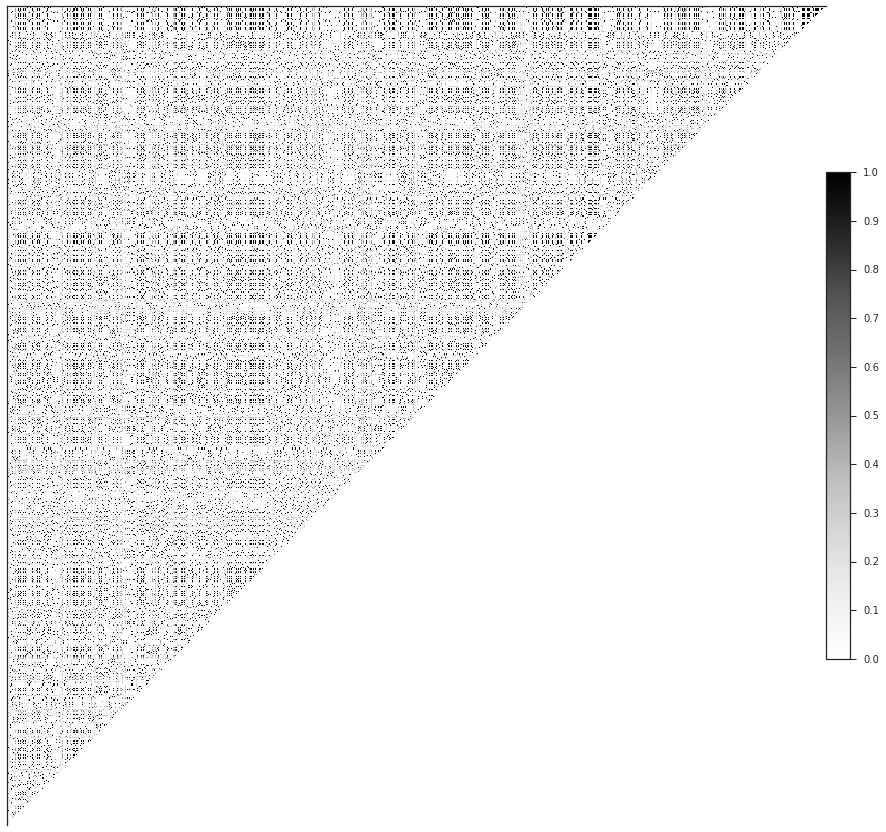

In [55]:
g = allel.GenotypeArray(cmask.genotype)
gn = g.to_n_alt()
m = allel.stats.rogers_huff_r(gn[:1000]) ** 2
ax = allel.plot.pairwise_ld(m)

In [ ]:
Below here is crap

In [41]:
vcall = vcfnp.variants(filename).view(np.recarray)

[vcfnp] 2016-09-03 22:22:16.869969 :: caching is disabled
[vcfnp] 2016-09-03 22:22:16.870600 :: building array


In [44]:
vcall

rec.array([('un', 259, '4_35', 'A', 'G', 0.0, (True,), 2, True, 0, 0.3330078125, 3),
 ('un', 286, '4_62', 'C', 'G', 0.0, (True,), 2, True, 0, 0.3330078125, 3),
 ('un', 354, '5_56', 'C', 'T', 0.0, (True,), 2, True, 0, 0.1429443359375, 7),
 ...,
 ('un', 36747942, '496594_58', 'A', 'T', 0.0, (True,), 2, True, 0, 0.5, 1),
 ('un', 36748542, '496602_66', 'A', 'T', 0.0, (True,), 2, True, 0, 0.5, 1),
 ('un', 36748683, '496604_59', 'A', 'G', 0.0, (True,), 2, True, 0, 0.5, 1)], 
          dtype=[('CHROM', 'S12'), ('POS', '<i4'), ('ID', 'S12'), ('REF', 'S12'), ('ALT', 'S12'), ('QUAL', '<f4'), ('FILTER', [('PASS', '?')]), ('num_alleles', 'u1'), ('is_snp', '?'), ('svlen', '<i4'), ('AF', '<f2'), ('NS', '<i4')])